In [42]:
# using Pkg
# Pkg.activate("./")

 Activating new environment at `~/Numerics/RigettiMatching/Project.toml`


In [1]:
using QSimulator 
# using Optim
# using LsqFit
# using NLsolve
# using Roots
# using QuadGK
using PyPlot
using LinearAlgebra
# using Interpolations
# using FFTW
using SpecialFunctions
# import Statistics

# import QuantumInfo: liou, avgfidelity, kraus2liou # open-source package
# import Cliffords: Z
# using Optim
using LinearAlgebra: diagm

┌ Info: Precompiling QSimulator [84ebd660-cff8-11e8-33d2-5334dd07f13c]
└ @ Base loading.jl:1423
┌ Warning: Package QSimulator does not have BSplineKit in its dependencies:
│ - If you have QSimulator checked out for development and have
│   added BSplineKit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QSimulator
└ Loading BSplineKit into QSimulator from project dependency, future warnings for QSimulator are suppressed.


In [2]:
# Make sure it's using the local development package
pathof(QSimulator)

"/Users/guenther5/.julia/environments/v1.7/dev/QSimulator/src/QSimulator.jl"

In [3]:
function erfsquare_with_pads(tramp,tf,pad_length,t)
    """
    Error function square pulse
    
    :param tramp:       rise and fall time of the pulse.
    :param tf:          length of the flux pulse (without pads).
    :paramp pad_length: length of pad to be added on each side of the pulse.
    : return errfun:    error function square pulse.
    """
    fwhm = 0.5*tramp
    σ = fwhm/(2.0*sqrt(2.0 *log(2.0)))
    errfun = 0.5*(erf((t -pad_length- tramp)/σ)-erf((t + tramp - pad_length - tf)/σ))
    if t <= pad_length
        return  0
    elseif pad_length <= t <= tf+pad_length 
        return errfun
    elseif tf+pad_length  < t <= tf + 2*pad_length
    return 0
    end
end

erfsquare_with_pads (generic function with 1 method)

In [4]:
#define operators
σ0 = [0.0 1.0 0.0;0.0 0.0 √2.0;0.0 0.0 0.0]    
σz = σ0'*σ0
σ1z = [-1.0 0.0;0.0 1.0]⊗ Matrix(I,2,2)
σ2z =  Matrix(I,2,2)⊗[-1.0 0.0;0.0 1.0]
UiSWAP = [1.0 0.0 0.0 0.0 ;0.0 0.0 1im 0.0; 0.0 1im 0.0 0.0; 0.0 0.0 0.0 1.0]
UCZ = [1.0 0.0 0.0 0.0 ;0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 -1.0]
ln = [1 2 4 5 10 11 13 14 28 29 31 32 37 38 40 41] # indces of initial conditions
Iden = [1.0 0.0 0.0; 0.0 1.0 0.0]⊗[1.0 0.0 0.0; 0.0 1.0 0.0];

In [5]:
# Modulation frequencies 
fm_opt_list_CZ = [0.29297, 0.48572]
fm_opt_list_iSWAP = [0.39222]
println("modulation frequency for CZ02 = ", round(fm_opt_list_CZ[1]*1000,digits=2), " MHz")
println("modulation frequency for CZ20 = ", round(fm_opt_list_CZ[2]*1000,digits=2), " MHz")
println("modulation frequency for iSWAP = ", round(fm_opt_list_iSWAP[1]*1000,digits=2), " MHz")

modulation frequency for CZ02 = 292.97 MHz
modulation frequency for CZ20 = 485.72 MHz
modulation frequency for iSWAP = 392.22 MHz


In [6]:
# CZ GATE TIMES 
gatetime_CZ_optimal = [105.15693358991508, 174.86605293763594]

tramp = 8 # ramp time of the flux pulse
pad_length = 8 # padding on each side of the flux pulse 
tf_CZ = gatetime_CZ_optimal .+ 2*tramp
tf_CZ_with_pads = tf_CZ .+ 2*pad_length
println("CZ optimal gate times: ", gatetime_CZ_optimal)

# iSWAP gate times
gatetime_iSWAP_optimal= 99.5250113474233
tf_iSWAP = gatetime_iSWAP_optimal .+ 2*tramp
tf_iSWAP_with_pads = tf_iSWAP .+ 2*pad_length
println("iSWAP optimal gate time: ", gatetime_iSWAP_optimal)

CZ optimal gate times: [105.15693358991508, 174.86605293763594]
iSWAP optimal gate time: 99.5250113474233


In [7]:
# Set up the oscillators 

# (1) fixed-frequency transmon 
f01_f, eta_f = [3.887,0.187]
q1 = DuffingTransmon("q1", 3, DuffingSpec(f01_f, -eta_f) ) 

# (2) tunable transmon
EJ_small, EJ_large, Ec = [3.0729953809760047,17.50233502578641,0.18109155430615317]
q0 = PerturbativeTransmon("q0", 3, TransmonSpec(Ec, EJ_large, EJ_small))  

# drive amplitude for tunable transmon
phim = 0.6  # in units of Phi0. AC sweet spot amplitude


# Coupling
g01 =  0.010

0.01

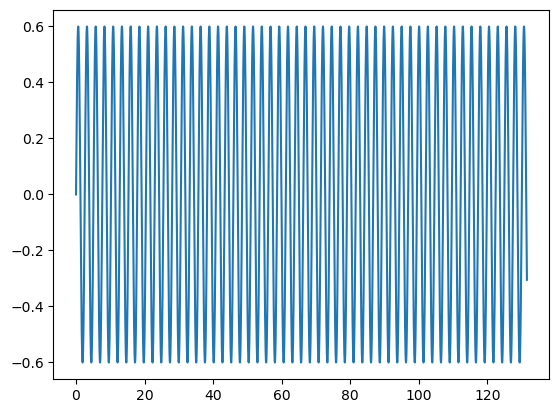

times=[0.0:131.52] drive freq=0.39222

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/guenther5/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [8]:
# CZ20 drive for tunable transmon
# times = collect(0.0:0.01:tf_CZ_with_pads[1])
# driveq0 = t -> phim*erfsquare_with_pads(tramp,tf_CZ[1],pad_length,t).*sin(2π*fm_opt_list_CZ[1]*t)

# iSWAP drive for tunable transmon
times = collect(0.0:0.01:tf_iSWAP_with_pads)
# driveq0 = t -> phim*erfsquare_with_pads(tramp,tf_iSWAP,pad_length,t).*sin(2π*fm_opt_list_iSWAP[1]*t)
# driveq0 = t -> phim.*sin(2π*fm_opt_list_iSWAP[1]*t)
driveq0 = t -> phim.*sin.(2π*fm_opt_list_iSWAP[1]*t)

plot(times, driveq0(times))
print("times=[", times[1],":", times[end], "] ", "drive freq=",fm_opt_list_iSWAP[1])

In [9]:
# Construct the system 
cqs = CompositeQSystem([q0, q1])
add_hamiltonian!(cqs, q1)  # fixed transmon
add_hamiltonian!(cqs, parametric_drive(q0, driveq0), q0) # tunable transmon
add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1]) #coupling


# Initial density matrix rhoin = |10><10|
rho0=zeros(ComplexF64,9,9)
rho0[4,4] = 1.0 + im*0.0  
# print(rhoin)

# Initial state vector in 3x3 system
phi0 = zeros(ComplexF64,9) 
phi0[4] = 1.0 + im*0.0     #|10>

# RUN
# rho_all = me_state(cqs, times, rho0);
phi_all = unitary_state(cqs, times, phi0);
# times[end]

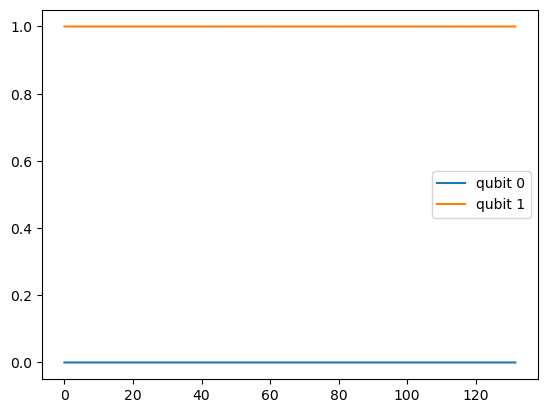

PyObject <matplotlib.legend.Legend object at 0x2300173a0>

In [10]:
# Compute population from state vector
g_q0 = [ [ abs2(s[1]) + abs2(s[2]) + abs2(s[3]) ] for s in phi_all ]
e_q0 = [ [ abs2(s[4]) + abs2(s[5]) + abs2(s[6]) ] for s in phi_all ]
ee_q0 = [ [ abs2(s[7]) + abs2(s[8]) + abs2(s[9]) ] for s in phi_all ]
g_q1 = [ [ abs2(s[1]) + abs2(s[4]) + abs2(s[7]) ] for s in phi_all ]
e_q1 = [ [ abs2(s[2]) + abs2(s[5]) + abs2(s[8]) ] for s in phi_all ]
ee_q1 = [ [ abs2(s[3]) + abs2(s[6]) + abs2(s[9]) ] for s in phi_all ]
plot(times, g_q0, label="qubit 0")
plot(times, g_q1, label="qubit 1")
legend()

In [11]:
# Compute population from density matrix
rho_diag = [ [real(s[i, i]) for i in 1:size(rho_all[end])[1] ] for s in rho_all] 

# Population qubit 0: reduce over second qubit
# ground state (gg) and first excited state (ff)
g_q0 = [  [s[1] + s[2] + s[3] ] for s in rho_diag]
e_q0 = [  [s[4] + s[5] + s[6] ] for s in rho_diag]

# Population qubit 1: reduce over first qubit
# ground state (gg) and first excited state (ff)
g_q1 = [  [s[1] + s[4] + s[7] ] for s in rho_diag]
e_q1 = [  [s[2] + s[5] + s[8] ] for s in rho_diag]

plot(times, g_q0, label="qubit 0")
plot(times, g_q1, label="qubit 1")
ylabel("Ground state population")
legend()

LoadError: UndefVarError: rho_all not defined

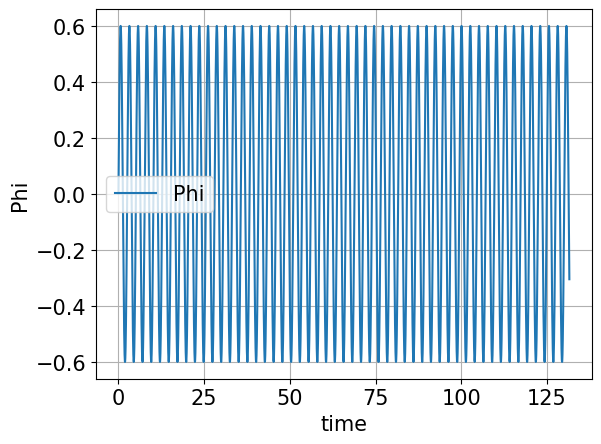

PyObject Text(30.0, 0.5, 'Phi')

In [12]:
# Plot the drive
mydrive = driveq0.(times)

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15

plot(times, mydrive, label="Phi")
legend()
grid()
xlabel("time")
ylabel("Phi")


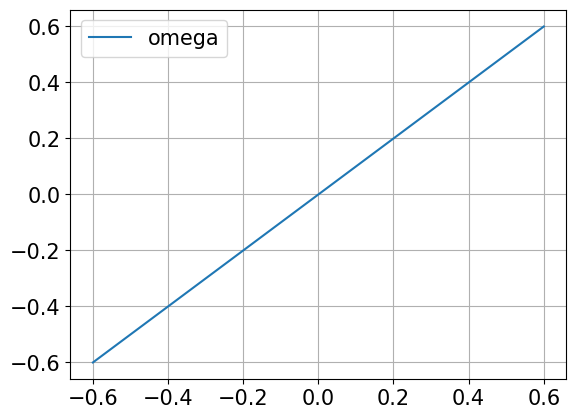

In [13]:
# plot and fit w(x)
# omega = perturbative_transmon_freq.(Ec, EJ_small, EJ_large, driveq0.(times))

x = collect(-0.6:0.01:0.6)
omega = perturbative_transmon_freq.(Ec, EJ_small, EJ_large, x)
plot(x, omega, label="omega")

# # Use a Bspine to fit omega
# using BSplineKit
# print(omega)
# order = 2
# spline_omega = interpolate(x, omega, BSplineOrder(order))

# fit = spline_omega.(x)
# fit = 0.444*sin.(2*pi*(x.+0.25)).+4.826
# plot(x, fit, label="fit")
legend()
grid()

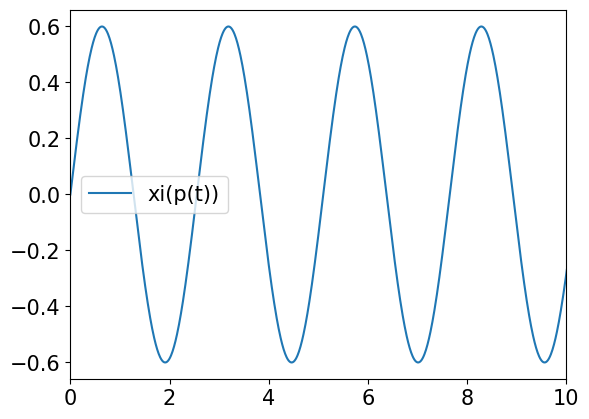

(0.0, 10.0)

In [14]:
# plot w(drive(t))
mydrive = driveq0.(times)
omega_drive = perturbative_transmon_freq.(Ec, EJ_small, EJ_large, mydrive)
xi_drive = perturbative_transmon_anharm.(Ec, EJ_small, EJ_large, mydrive)

# plot(times, omega_drive, label="w(p(t))")
plot(times, xi_drive, label="xi(p(t))")
legend()

#axis
ax = gca()
ax[:set_xlim]([0,10])

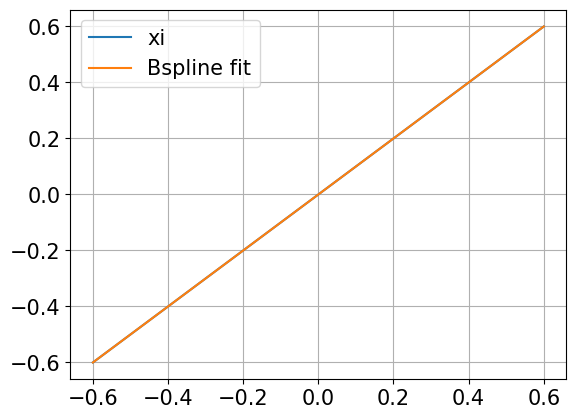

In [15]:
# Plot and fit xi(x)
x = collect(-0.6:0.01:0.6)
xi = perturbative_transmon_anharm.(Ec, EJ_small, EJ_large, x)

plot(x, xi, label="xi")

# Use a Bspine to fit xi
using BSplineKit
order = 2
spline_xi = interpolate(x, xi, BSplineOrder(order))

fit = spline_xi.(x)
# fit = 0.00194*sin.(2*pi*(x.+0.25)) .- 0.19904
plot(x, fit, label="Bspline fit")
legend()
grid()

In [14]:
# ORIGINAL: Fidelities of CZ gates with T1, T2
CZ_infidelity = []
rho_tstop = []
# for lm in 1:1:2  #iterates over gates CZ02 CZ20  
for lm in 1:1:1 
    tff = tf[lm] 
    
    times = collect(0.0:1:tf_with_pads[lm])

    rho_final = []
#     for k in 1:1:length(ln) # iterates over initial conditions
    for k in 1:1:1 # iterates over initial conditions
        IM = Matrix{ComplexF64}(I, 81,81)
        ρin = reshape(IM[:,ln[k]],9,9)
#         print("rho_in", ρin)

        cqs = CompositeQSystem([q0, q1]) # construct the composite system
        add_hamiltonian!(cqs, q1)
        add_hamiltonian!(cqs, parametric_drive(q0, t -> phim*erfsquare_with_pads(tramp,tff,pad_length,t).*sin(2π*fm_opt_list_CZ[lm]*t)), q0)
#         add_hamiltonian!(cqs, parametric_drive(q0, driveq0), q0)
        add_hamiltonian!(cqs, g01*X([q0, q1]), [q0,q1])
#         println(hamiltonian(cqs))
#         stop


#         add_lindblad!(cqs, sqrt(γ1t)*σ0, [q0])
#         add_lindblad!(cqs, sqrt(γϕt)*σz, [q0])
#         add_lindblad!(cqs, sqrt(γ1f)*σ0, [q1])
#         add_lindblad!(cqs, sqrt(γϕf)*σz, [q1])
        ρs = me_state(cqs, times, ρin);
#         print("rho_tstop = ", ρs[end])
        rho_tstop = ρs[end]
        
        ρf = Iden*reshape(ρs[end],9,9)*Iden' # project on to the computational subspace
        append!(rho_final,   [reshape(ρf,16,1)])
    end
#     UCZ = diagm(0 => [1.0,1.0,1.0,-1.0])
#     final_process_matrix  = hcat([rho_final[l] for l=1:length(ln)]...)     # noisey process matrix
#     push!(CZ_infidelity, infidelity(final_process_matrix,UCZ,zeros(2)))
end

LoadError: UndefVarError: tf not defined

In [15]:
print("ERROR=", norm(rho_tstop - rho_tstop_test))

LoadError: UndefVarError: rho_tstop_test not defined